In [ ]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 10]

In [ ]:
''' Activation Functions '''

def relu(x, p=False):
    if p: return 1 * (x > 0)
    return x * (x > 0)

def linear(x, p=False):
    if p: return np.ones_like(x)
    return x

In [ ]:
''' Cost Functions '''

def MSE(output_acts, y, p=False):
    if p: return (output_acts-y)
    return 0.5*(output_acts-y)**2

In [ ]:
''' Optimizer Class '''

class Optimizer:

    def __init__(self, name, args):
        self.name = name
        self.args = args
        self.eps = 1e-8
        self.lr = 0

    def initialize(self, vars):
        if self.name in 'sgd':
            self.momentum = [np.zeros(v.shape) for v in vars]
        
        if self.name == 'adagrad':
            self.second_moment = [np.zeros(v.shape) for v in vars]

        if self.name == 'rmsprop':
            self.second_moment = [np.zeros(v.shape) for v in vars]

        if self.name == 'adadelta':
            self.second_moment = [np.zeros(v.shape) for v in vars]
            self.second_moment_updates = [np.zeros(v.shape) for v in vars]

        if self.name == 'adam':
            self.t = 1 
            self.first_moment = [np.zeros(v.shape) for v in vars]
            self.second_moment = [np.zeros(v.shape) for v in vars]
        
    def set_lr(self, lr):
        self.lr = lr

    def update(self, var, nabla):
        if self.name == 'sgd':
            alpha = self.args['alpha']
            self.momentum = [alpha*m + self.lr*n 
                            for m, n in zip(self.momentum, nabla)]
            var = [v - m for v, m in zip(var, self.momentum)]

        elif self.name == 'adagrad':
            self.second_moment = [g + n**2 
                                  for g, n in zip(self.second_moment, nabla)]
            var = [v - (n*self.lr)/(np.sqrt(g) + self.eps)
                    for v, n, g in zip(var, nabla, self.second_moment)]                      

        elif self.name == 'rmsprop':
            decay_rate = self.args['decay_rate']
            self.second_moment = [decay_rate * m + (1-decay_rate) * (n**2)
                                  for m, n in zip(self.second_moment, nabla)]
            var = [v - (n*self.lr)/(np.sqrt(g) + self.eps)
                    for v, n, g in zip(var, nabla, self.second_moment)] 
        
        elif self.name == 'adadelta':
            decay_rate = self.args['decay_rate']
            self.second_moment = [decay_rate * m + (1-decay_rate) * (n**2)
                                  for m, n in zip(self.second_moment, nabla)]
            updates = [((np.sqrt(u) + self.eps)*n)/(np.sqrt(g) + self.eps)
                    for n, u, g in zip(nabla, self.second_moment_updates, self.second_moment)]
            var = [v - u for v, u in zip(var, updates)]
            self.second_moment_updates = [decay_rate * m + (1-decay_rate) * (u**2)
                                          for m, u in zip(self.second_moment_updates, updates)]

        elif self.name == 'adam':
            beta1 = self.args['beta1']
            beta2 = self.args['beta2']
            self.t += 1
            self.first_moment = [beta1 * m + (1-beta1) * n
                                  for m, n in zip(self.first_moment, nabla)]
            self.second_moment = [beta2 * m + (1-beta2) * (n**2)
                                  for m, n in zip(self.second_moment, nabla)]
            fm_hat = [m/(1-(beta1**self.t)) for m in self.first_moment]
            sm_hat = [m/(1-(beta2**self.t)) for m in self.second_moment]
            var = [v - (m*self.lr)/(np.sqrt(g) + self.eps)
                    for v, m, g in zip(var, fm_hat, sm_hat)]

        return var


In [ ]:
''' Learning Rate Schedulers '''

def constant(lr, epoch):
    return lr

def time_decay(lr, epoch, decay_rate):
    return lr / (1. + decay_rate*epoch)

def exp_decay(lr, epoch, decay_rate):
    return lr * np.exp(-epoch*decay_rate)

def step_decay(lr, epoch, decay_rate, decay_step):
    return lr * decay_rate**(np.floor(epoch/decay_step))

In [ ]:
''' Network Class '''

class Network:

    def __init__(self, s=43):
        np.random.seed(s)
        self.layer_cnt = 0
        self.weights = []
        self.biases = []
        self.act_funcs = []
        self.report = dict()
        self.report['loss'] = []
        self.report['re'] = []

    def dense(self, neuron_cnt, act_func, input_shape=None):
        if self.layer_cnt == 0 and (not input_shape):
            raise Exception('First Layer Must Have Input Shape')

        self.layer_cnt += 1

        if self.layer_cnt == 1:
            self.weights.append(np.random.normal(0, 0.05, (neuron_cnt, input_shape)))
        else:
            self.weights.append(np.random.normal(0, 0.05, (neuron_cnt, self.weights[-1].shape[0])))

        self.biases.append(np.zeros((neuron_cnt, 1)))
        self.act_funcs.append(act_func)

    def feedforward(self, x):
        pre_acts, acts = [], []
        act = np.array(x)

        acts.append(act)

        for w, b, a in zip(self.weights, self.biases, self.act_funcs):
            pre_act = np.dot(w, act) + b
            act = a(pre_act)
            pre_acts.append(pre_act)
            acts.append(act)

        return pre_acts, acts, act

    def backprop(self, x, y, cost_func):
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]

        pre_acts, acts, out = self.feedforward(x)

        delta = cost_func(acts[-1], y, p=True) * self.act_funcs[-1](pre_acts[-1], p=True)
        nabla_w[-1] = np.dot(delta, acts[-2].T)
        nabla_b[-1] = delta

        for i in range(2, self.layer_cnt+1):
            delta = np.dot(self.weights[-i+1].T, delta) * self.act_funcs[-i](pre_acts[-i], p=True)
            nabla_w[-i] = np.dot(delta, acts[-i-1].T)
            nabla_b[-i] = delta

        return nabla_w, nabla_b, out

    def next_mini_batch(self, dataset, batch_size):
        N = dataset['count']
        indxs = np.arange(N)
        np.random.shuffle(indxs)

        for i in range(0, N-batch_size+1, batch_size):
            mini_batch = indxs[i:i+batch_size]
            yield zip(dataset['X'][mini_batch], dataset['y'][mini_batch])

    def learn(self, cost_func, epochs, dataset,
            opt_args, lr_schedulers, nasterov=False,
            eta=0.001, alpha=0.9, batch_size=32, verbos=1):
        
        optimizer_b = Optimizer(*opt_args)
        optimizer_w = Optimizer(*opt_args)
        optimizer_b.initialize(self.biases)
        optimizer_w.initialize(self.weights)

        for i in tqdm(range(epochs), disable=(not verbos)):
            eta_ = lr_schedulers(eta, i)
            lr = eta_/batch_size
            optimizer_b.set_lr(lr)
            optimizer_w.set_lr(lr)

            y_, y_h = [], []

            for mini_batch in self.next_mini_batch(dataset, batch_size):
                nabla_b = [np.zeros(b.shape) for b in self.biases]
                nabla_w = [np.zeros(w.shape) for w in self.weights]

                if nasterov:
                    self.biases = [b + alpha*m 
                                   for b, m in zip(self.biases, optimizer_b.momentum)]
                    self.weights = [w + alpha*m 
                                    for w, m in zip(self.weights, optimizer_w.momentum)]

                for x, y in mini_batch:
                    delta_nabla_w, delta_nabla_b, out = self.backprop(x, y, cost_func)
                    nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)] 
                    nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
                    y_.append(y)
                    y_h.append(out)

                self.biases = optimizer_b.update(self.biases, nabla_b)
                self.weights =  optimizer_w.update(self.weights, nabla_w)

            y_, y_h = np.array(y_).ravel(), np.array(y_h).ravel()
            self.report['loss'].append(np.mean(cost_func(y_h, y_)))
            self.report['re'].append(np.mean(np.abs((y_h-y_)/y_)))

            if verbos == 1:
                print('loss: ', self.report['loss'][-1],
                      'reletive error: ', self.report['re'][-1])

    def reset(self):
        self.biases = [np.random.rand(*b.shape) for b in self.biases]
        self.weights = [np.random.rand(*w.shape) for w in self.weights]
        self.report['loss'] = []
        self.report['re'] = []

In [ ]:
''' Dataset Functions '''

def make_dataset(N):
    dataset = dict()
    dataset['count'] = N
    dataset['X'] = np.random.uniform(-1, 1, (N, 10, 1))
    dataset['y'] = np.sin(np.mean(dataset['X'][:, :5], axis=1)) + \
                    np.cos(np.mean(dataset['X'][:, 5:], axis=1))

    return dataset





  0%|          | 0/50 [00:00<?, ?it/s]



  2%|▏         | 1/50 [00:00<00:39,  1.23it/s]

loss:  4906.423901908728 reletive error:  72.50579794449294






  4%|▍         | 2/50 [00:01<00:39,  1.21it/s]

loss:  3103.063353849766 reletive error:  57.86290777050448






  6%|▌         | 3/50 [00:02<00:37,  1.24it/s]

loss:  1912.233124365663 reletive error:  45.562483831829184






  8%|▊         | 4/50 [00:03<00:36,  1.27it/s]

loss:  1113.5104968000949 reletive error:  34.83889685336806






 10%|█         | 5/50 [00:03<00:35,  1.27it/s]

loss:  604.2133093650776 reletive error:  25.684969494858755






 12%|█▏        | 6/50 [00:04<00:33,  1.30it/s]

loss:  290.5678500063207 reletive error:  17.770463684856953






 14%|█▍        | 7/50 [00:05<00:32,  1.30it/s]

loss:  113.34559550696251 reletive error:  10.980440451905425






 16%|█▌        | 8/50 [00:06<00:31,  1.32it/s]

loss:  28.656022883478542 reletive error:  5.254538878980673






 18%|█▊        | 9/50 [00:06<00:30,  1.33it/s]

loss:  2.180537772573839 reletive error:  1.2263253446930944






 20%|██        | 10/50 [00:07<00:31,  1.29it/s]

loss:  0.16994936888850123 reletive error:  0.4550724957363749






 22%|██▏       | 11/50 [00:08<00:30,  1.29it/s]

loss:  0.04544219428309829 reletive error:  0.2655376552682763






 24%|██▍       | 12/50 [00:09<00:29,  1.30it/s]

loss:  0.023414652427055593 reletive error:  0.2010653334124203






 26%|██▌       | 13/50 [00:10<00:28,  1.31it/s]

loss:  0.016270257690178137 reletive error:  0.16820795880307735






 28%|██▊       | 14/50 [00:10<00:27,  1.29it/s]

loss:  0.011586150210379013 reletive error:  0.14276609114107713






 30%|███       | 15/50 [00:11<00:27,  1.30it/s]

loss:  0.008509574173955627 reletive error:  0.12300739740295323






 32%|███▏      | 16/50 [00:12<00:25,  1.31it/s]

loss:  0.006560517322874543 reletive error:  0.1084204252293127






 34%|███▍      | 17/50 [00:13<00:25,  1.32it/s]

loss:  0.005236292465013713 reletive error:  0.09732976328713062






 36%|███▌      | 18/50 [00:13<00:24,  1.30it/s]

loss:  0.004344158148727957 reletive error:  0.08872332416782523






 38%|███▊      | 19/50 [00:14<00:23,  1.31it/s]

loss:  0.0037142366145622896 reletive error:  0.08195700753378246






 40%|████      | 20/50 [00:15<00:23,  1.26it/s]

loss:  0.0032361694024761085 reletive error:  0.07625383643229652






 42%|████▏     | 21/50 [00:16<00:22,  1.28it/s]

loss:  0.002869930311050152 reletive error:  0.07150028705948733






 44%|████▍     | 22/50 [00:16<00:21,  1.30it/s]

loss:  0.0025850586249927913 reletive error:  0.06764891276260909






 46%|████▌     | 23/50 [00:17<00:20,  1.30it/s]

loss:  0.0023446105318122926 reletive error:  0.06426572619728624






 48%|████▊     | 24/50 [00:18<00:19,  1.32it/s]

loss:  0.002137386594744102 reletive error:  0.06112708395358634






 50%|█████     | 25/50 [00:19<00:19,  1.31it/s]

loss:  0.0019689549112874493 reletive error:  0.05845697915469017






 52%|█████▏    | 26/50 [00:20<00:18,  1.30it/s]

loss:  0.0018095708192298404 reletive error:  0.055907771395104874






 54%|█████▍    | 27/50 [00:20<00:17,  1.31it/s]

loss:  0.001673482989917602 reletive error:  0.05368836620538075






 56%|█████▌    | 28/50 [00:21<00:16,  1.32it/s]

loss:  0.0015467601206920311 reletive error:  0.05158826246504653






 58%|█████▊    | 29/50 [00:22<00:16,  1.25it/s]

loss:  0.0014288923740463292 reletive error:  0.049500518188159766






 60%|██████    | 30/50 [00:23<00:15,  1.27it/s]

loss:  0.001325506042729922 reletive error:  0.04759108904166037






 62%|██████▏   | 31/50 [00:23<00:14,  1.29it/s]

loss:  0.0012251066082829064 reletive error:  0.04564147609374719






 64%|██████▍   | 32/50 [00:24<00:13,  1.31it/s]

loss:  0.001138579081436112 reletive error:  0.043965036969259394






 66%|██████▌   | 33/50 [00:25<00:12,  1.32it/s]

loss:  0.001050072748781472 reletive error:  0.04218953039039503






 68%|██████▊   | 34/50 [00:26<00:12,  1.33it/s]

loss:  0.0009659671590279103 reletive error:  0.04034169650649515






 70%|███████   | 35/50 [00:26<00:11,  1.33it/s]

loss:  0.0008933811052290375 reletive error:  0.03892689570492745






 72%|███████▏  | 36/50 [00:27<00:10,  1.33it/s]

loss:  0.00082433567929496 reletive error:  0.03730695247090453






 74%|███████▍  | 37/50 [00:28<00:09,  1.34it/s]

loss:  0.0007556961289550693 reletive error:  0.03569074565505085






 76%|███████▌  | 38/50 [00:29<00:09,  1.33it/s]

loss:  0.0006911828202893894 reletive error:  0.034119668090413356






 78%|███████▊  | 39/50 [00:29<00:08,  1.32it/s]

loss:  0.0006388574970039124 reletive error:  0.03275003807387366






 80%|████████  | 40/50 [00:30<00:07,  1.28it/s]

loss:  0.0005942554700226534 reletive error:  0.031492065023272446






 82%|████████▏ | 41/50 [00:31<00:06,  1.29it/s]

loss:  0.0005473257395498314 reletive error:  0.030148269209866966






 84%|████████▍ | 42/50 [00:32<00:06,  1.30it/s]

loss:  0.0005049464182583911 reletive error:  0.028975186980412






 86%|████████▌ | 43/50 [00:33<00:05,  1.27it/s]

loss:  0.00046431398111871757 reletive error:  0.027668397091249602






 88%|████████▊ | 44/50 [00:33<00:04,  1.27it/s]

loss:  0.0004338450152762696 reletive error:  0.02660207872468697






 90%|█████████ | 45/50 [00:34<00:03,  1.29it/s]

loss:  0.0004025538967511803 reletive error:  0.02554357433309383






 92%|█████████▏| 46/50 [00:35<00:03,  1.30it/s]

loss:  0.0003740252957859957 reletive error:  0.02450981736373868






 94%|█████████▍| 47/50 [00:36<00:02,  1.25it/s]

loss:  0.00034903644248937825 reletive error:  0.02369676107414925






 96%|█████████▌| 48/50 [00:37<00:01,  1.26it/s]

loss:  0.0003336762330441644 reletive error:  0.02292119284960059






 98%|█████████▊| 49/50 [00:37<00:00,  1.28it/s]

loss:  0.0003094251659146851 reletive error:  0.022178822069072922






100%|██████████| 50/50 [00:38<00:00,  1.30it/s]




  0%|          | 0/50 [00:00<?, ?it/s]

loss:  0.0002961475635202998 reletive error:  0.021577277885588064






  2%|▏         | 1/50 [00:00<00:37,  1.29it/s]

loss:  6521.98357388806 reletive error:  87.86516275715006






  4%|▍         | 2/50 [00:01<00:37,  1.29it/s]

loss:  4395.725559934015 reletive error:  72.48075153419403






  6%|▌         | 3/50 [00:02<00:37,  1.27it/s]

loss:  3005.222207493905 reletive error:  60.18437092414729






  8%|▊         | 4/50 [00:03<00:36,  1.27it/s]

loss:  2055.968395922229 reletive error:  49.957186971862185






 10%|█         | 5/50 [00:04<00:36,  1.23it/s]

loss:  1393.427333289233 reletive error:  41.33530250546692






 12%|█▏        | 6/50 [00:04<00:35,  1.25it/s]

loss:  927.2699773428203 reletive error:  33.79416769641433






 14%|█▍        | 7/50 [00:05<00:34,  1.25it/s]

loss:  598.9710505922715 reletive error:  27.24151827293323






 16%|█▌        | 8/50 [00:06<00:33,  1.27it/s]

loss:  370.0448031015033 reletive error:  21.485992384322884






 18%|█▊        | 9/50 [00:07<00:32,  1.27it/s]

loss:  214.63653715424826 reletive error:  16.379115920255316






 20%|██        | 10/50 [00:07<00:31,  1.27it/s]

loss:  113.88686219691499 reletive error:  11.956627032823924






 22%|██▏       | 11/50 [00:08<00:30,  1.28it/s]

loss:  53.06401573864748 reletive error:  8.175403500275738






 24%|██▍       | 12/50 [00:09<00:31,  1.21it/s]

loss:  20.52290987551954 reletive error:  5.072569479193029






 26%|██▌       | 13/50 [00:10<00:30,  1.19it/s]

loss:  6.126706317646912 reletive error:  2.7572920240088163






 28%|██▊       | 14/50 [00:11<00:30,  1.20it/s]

loss:  1.3739171769359146 reletive error:  1.3044332497656792






 30%|███       | 15/50 [00:12<00:28,  1.22it/s]

loss:  0.3461480044668473 reletive error:  0.6989315298169558






 32%|███▏      | 16/50 [00:12<00:27,  1.22it/s]

loss:  0.21421750780884657 reletive error:  0.5638969899253631






 34%|███▍      | 17/50 [00:13<00:26,  1.24it/s]

loss:  0.1937123397257052 reletive error:  0.5357887380551494






 36%|███▌      | 18/50 [00:14<00:25,  1.25it/s]

loss:  0.1765135779870048 reletive error:  0.5119948831517426






 38%|███▊      | 19/50 [00:15<00:24,  1.24it/s]

loss:  0.15637525867370458 reletive error:  0.4832205928045406






 40%|████      | 20/50 [00:16<00:24,  1.22it/s]

loss:  0.1337166000931719 reletive error:  0.4490287942206922






 42%|████▏     | 21/50 [00:16<00:23,  1.24it/s]

loss:  0.10969401218106045 reletive error:  0.4089903993533353






 44%|████▍     | 22/50 [00:17<00:22,  1.25it/s]

loss:  0.08601830951186615 reletive error:  0.364114808895369






 46%|████▌     | 23/50 [00:18<00:21,  1.26it/s]

loss:  0.06460414637108892 reletive error:  0.3176395114585206






 48%|████▊     | 24/50 [00:19<00:20,  1.26it/s]

loss:  0.04697556305682973 reletive error:  0.27218512988712346






 50%|█████     | 25/50 [00:20<00:19,  1.27it/s]

loss:  0.03387866474969358 reletive error:  0.23264254837441112






 52%|█████▏    | 26/50 [00:20<00:18,  1.27it/s]

loss:  0.024945033010186263 reletive error:  0.19998476221876782






 54%|█████▍    | 27/50 [00:21<00:18,  1.27it/s]

loss:  0.019096960782780777 reletive error:  0.17430290726520056






 56%|█████▌    | 28/50 [00:22<00:17,  1.27it/s]

loss:  0.015286504208645312 reletive error:  0.15448084783097873






 58%|█████▊    | 29/50 [00:23<00:16,  1.26it/s]

loss:  0.012629482175858206 reletive error:  0.1390178497222299






 60%|██████    | 30/50 [00:24<00:15,  1.26it/s]

loss:  0.010611634406290205 reletive error:  0.12666801385967935






 62%|██████▏   | 31/50 [00:24<00:15,  1.26it/s]

loss:  0.008952712609742687 reletive error:  0.11614607511598206






 64%|██████▍   | 32/50 [00:25<00:14,  1.26it/s]

loss:  0.007507587863820823 reletive error:  0.10686216879999301






 66%|██████▌   | 33/50 [00:26<00:13,  1.27it/s]

loss:  0.006222473257985693 reletive error:  0.0977540822275906






 68%|██████▊   | 34/50 [00:27<00:12,  1.27it/s]

loss:  0.005139585623291513 reletive error:  0.08945385611746669






 70%|███████   | 35/50 [00:27<00:11,  1.28it/s]

loss:  0.004273229895507856 reletive error:  0.08196232390008638






 72%|███████▏  | 36/50 [00:28<00:10,  1.29it/s]

loss:  0.003594376113795792 reletive error:  0.07559610120428446






 74%|███████▍  | 37/50 [00:29<00:10,  1.28it/s]

loss:  0.0030923534848885962 reletive error:  0.0705830326449357






 76%|███████▌  | 38/50 [00:30<00:09,  1.28it/s]

loss:  0.0027272204319905274 reletive error:  0.06657624960633642






 78%|███████▊  | 39/50 [00:31<00:08,  1.28it/s]

loss:  0.00243465165848769 reletive error:  0.06274045917634397






 80%|████████  | 40/50 [00:31<00:07,  1.29it/s]

loss:  0.002203282285093666 reletive error:  0.059904790862890286






 82%|████████▏ | 41/50 [00:32<00:06,  1.29it/s]

loss:  0.0020092126020976775 reletive error:  0.057168771085614835






 84%|████████▍ | 42/50 [00:33<00:06,  1.28it/s]

loss:  0.0018270672197002868 reletive error:  0.05461349998444015






 86%|████████▌ | 43/50 [00:34<00:05,  1.28it/s]

loss:  0.001662236021721798 reletive error:  0.0520965732158611






 88%|████████▊ | 44/50 [00:35<00:04,  1.25it/s]

loss:  0.001501750165092484 reletive error:  0.04940124051432843






 90%|█████████ | 45/50 [00:35<00:03,  1.26it/s]

loss:  0.0013504656423771022 reletive error:  0.04686739483725356






 92%|█████████▏| 46/50 [00:36<00:03,  1.26it/s]

loss:  0.0012143353749459363 reletive error:  0.04441023397297707






 94%|█████████▍| 47/50 [00:37<00:02,  1.27it/s]

loss:  0.001098012672859595 reletive error:  0.04237205730935153






 96%|█████████▌| 48/50 [00:38<00:01,  1.27it/s]

loss:  0.0009880918852672692 reletive error:  0.040098781903941824






 98%|█████████▊| 49/50 [00:38<00:00,  1.28it/s]

loss:  0.00088324310845115 reletive error:  0.037896389400593526






100%|██████████| 50/50 [00:39<00:00,  1.26it/s]

loss:  0.0007953369909947372 reletive error:  0.035995130632242925


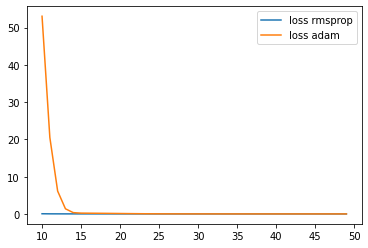

In [ ]:
mynet = Network()

mynet.dense(16, relu, 10)
mynet.dense(32, relu)
mynet.dense(1, linear)

mydata = make_dataset(10000)
x = np.arange(10, 50)

lr_schedulers = lambda lr, epoch: constant(lr, epoch)

# optimizer = ('sgd', {'alpha':0.9})

# mynet.reset()
# mynet.learn(MSE, 50, mydata, optimizer, lr_schedulers, nasterov=True,
#             eta=0.0002, batch_size=16, alpha=0.9, verbos=1)
# plt.plot(x, mynet.report['loss'][10:], label="loss sgd nasterov")

# optimizer = ('adagrad', {})

# mynet.reset()
# mynet.learn(MSE, 50, mydata, optimizer, lr_schedulers, nasterov=False,
#             eta=0.1, batch_size=4, alpha=0.9, verbos=1)
# plt.plot(x, mynet.report['loss'][10:], label="loss adagrad")

optimizer = ('rmsprop', {'decay_rate':0.99})

mynet.reset()
mynet.learn(MSE, 50, mydata, optimizer, lr_schedulers, nasterov=False,
            eta=0.001, batch_size=16, alpha=0.9, verbos=1)
plt.plot(x, mynet.report['loss'][10:], label="loss rmsprop")

# optimizer = ('adadelta', {'decay_rate':0.9})

# mynet.reset()
# mynet.learn(MSE, 50, mydata, optimizer, lr_schedulers, nasterov=False,
#             eta=0.001, batch_size=4, alpha=0.9, verbos=1)
# plt.plot(x, mynet.report['loss'][10:], label="loss adadelta")

optimizer = ('adam', {'beta1':0.9, 'beta2':0.999})

mynet.reset()
mynet.learn(MSE, 50, mydata, optimizer, lr_schedulers, nasterov=False,
            eta=0.001, batch_size=16, alpha=0.9, verbos=1)
plt.plot(x, mynet.report['loss'][10:], label="loss adam")


plt.legend()
plt.show()